In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['font.family'] = "Libre Franklin"

In [3]:
import numpy as np
import pandas as pd
from mriqc_learn.datasets import load_dataset
from mriqc_learn.viz import metrics
from mriqc_learn.models.preprocess import SiteRobustScaler

# Load some example data

In [4]:
(train_x, train_y), (_, _) = load_dataset(split_strategy="none")

# Remove non-informative IQMs (image size and spacing)
train_x.drop(columns=["size_x", "size_y", "size_z", "spacing_x", "spacing_y", "spacing_z"])

# Get names of numeric columns
numeric_columns = train_x.columns.tolist()

train_x["site"] = train_y.site
ratings = np.array(["Exclude"] * len(train_x))

ratings[train_y.rater_3.values == 0] = "Doubtful"
ratings[train_y.rater_3.values == 1] = "Accept"

In [5]:
(test_x, test_y), (_, _) = load_dataset("ds030", split_strategy="none")

# Remove non-informative IQMs (image size and spacing)
test_x.drop(columns=["size_x", "size_y", "size_z", "spacing_x", "spacing_y", "spacing_z"])

test_x["site"] = test_y.site
ratings_test = np.array(["Exclude"] * len(test_x))

ratings_test[test_y.rater_1.values == 0] = "Doubtful"
ratings_test[test_y.rater_1.values == 1] = "Accept"

In [6]:
merged_x = pd.concat((train_x, test_x))

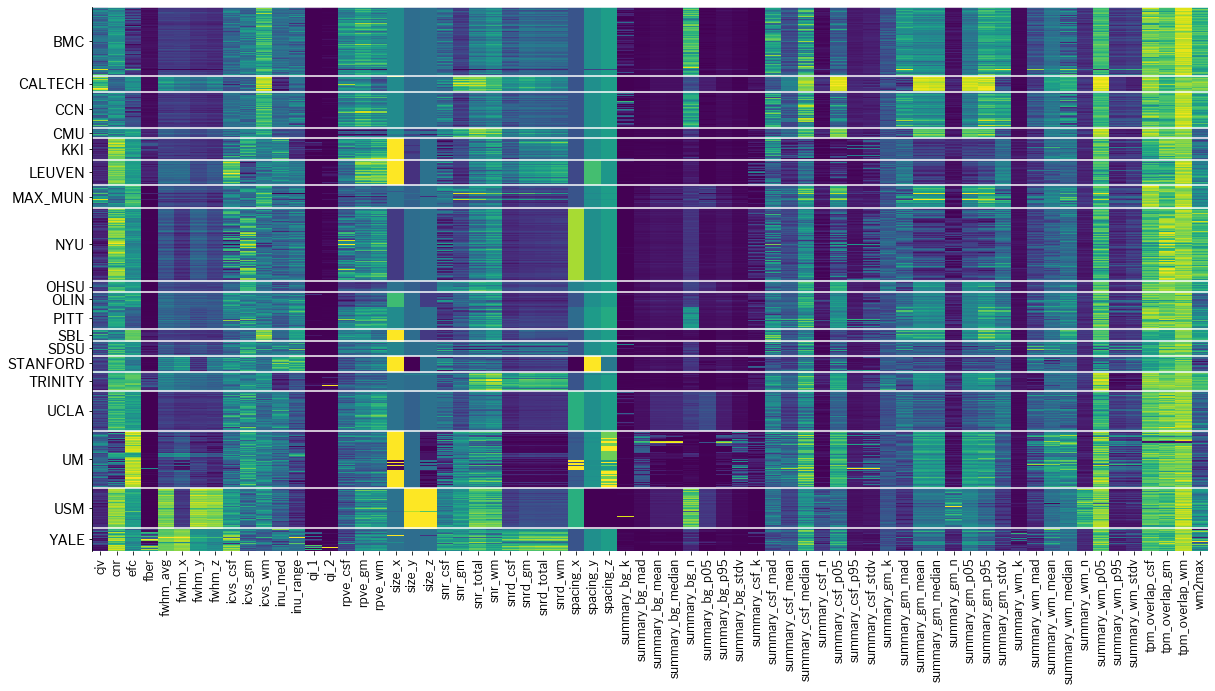

In [7]:
metrics.plot_batches(merged_x);

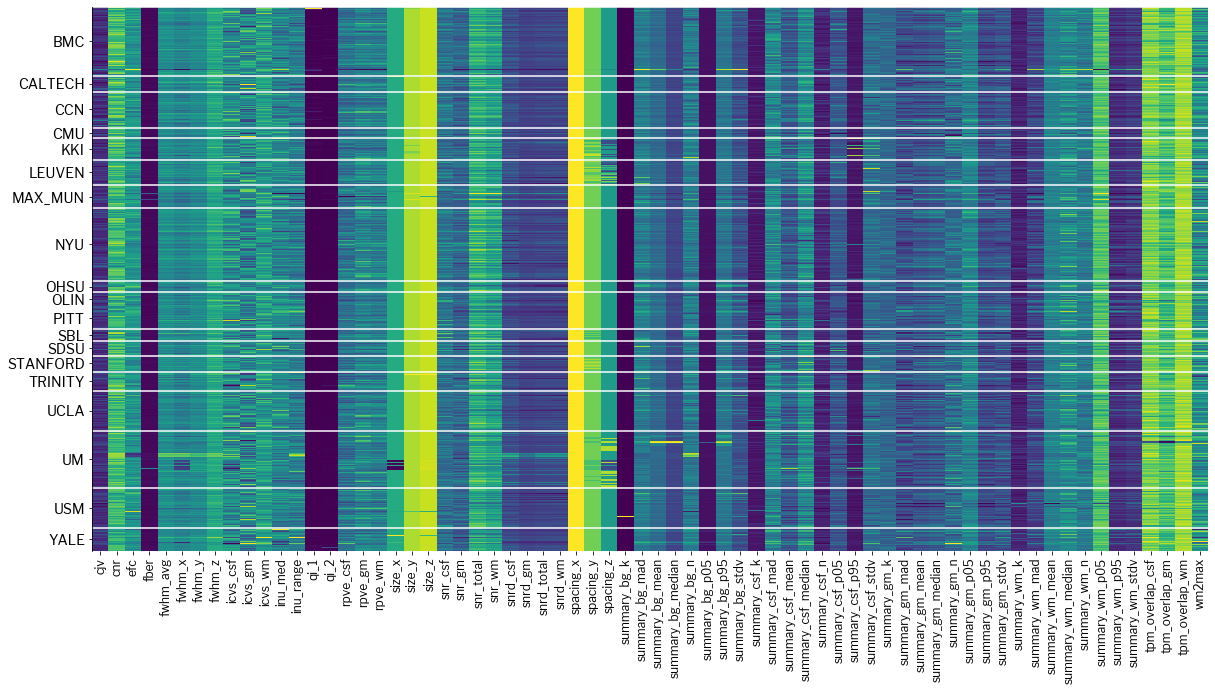

In [8]:
scaled_x = SiteRobustScaler(unit_variance=True).fit_transform(merged_x)
fig2 = metrics.plot_batches(scaled_x)

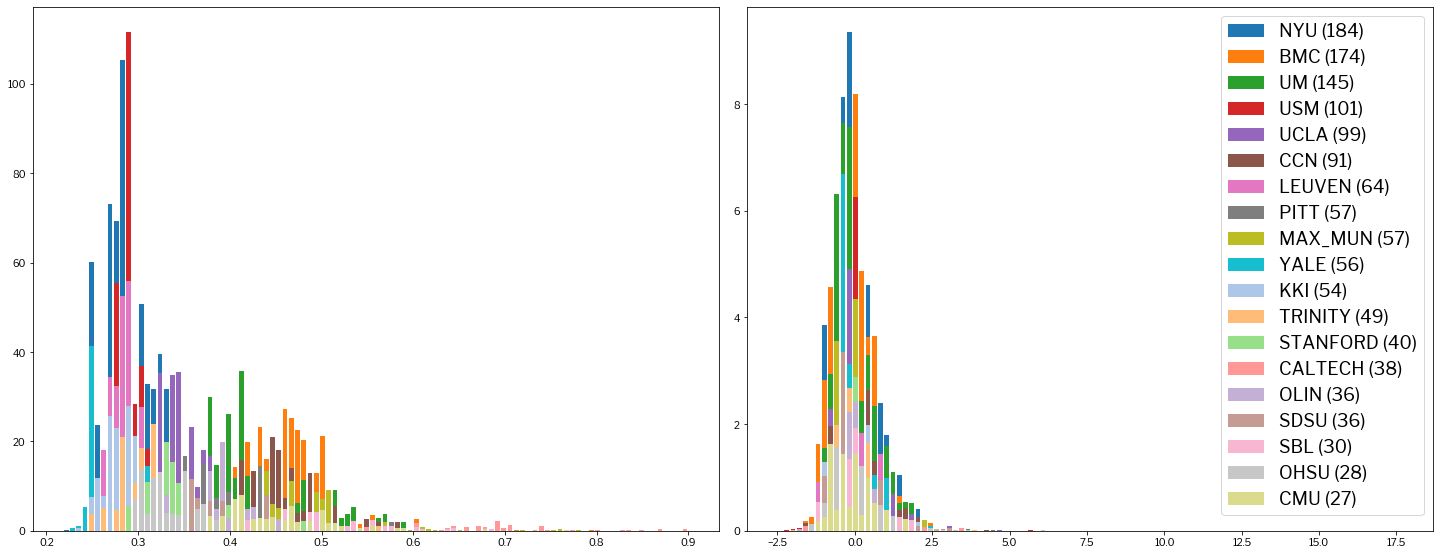

In [9]:
metrics.plot_histogram(merged_x, scaled_x, metric="cjv");

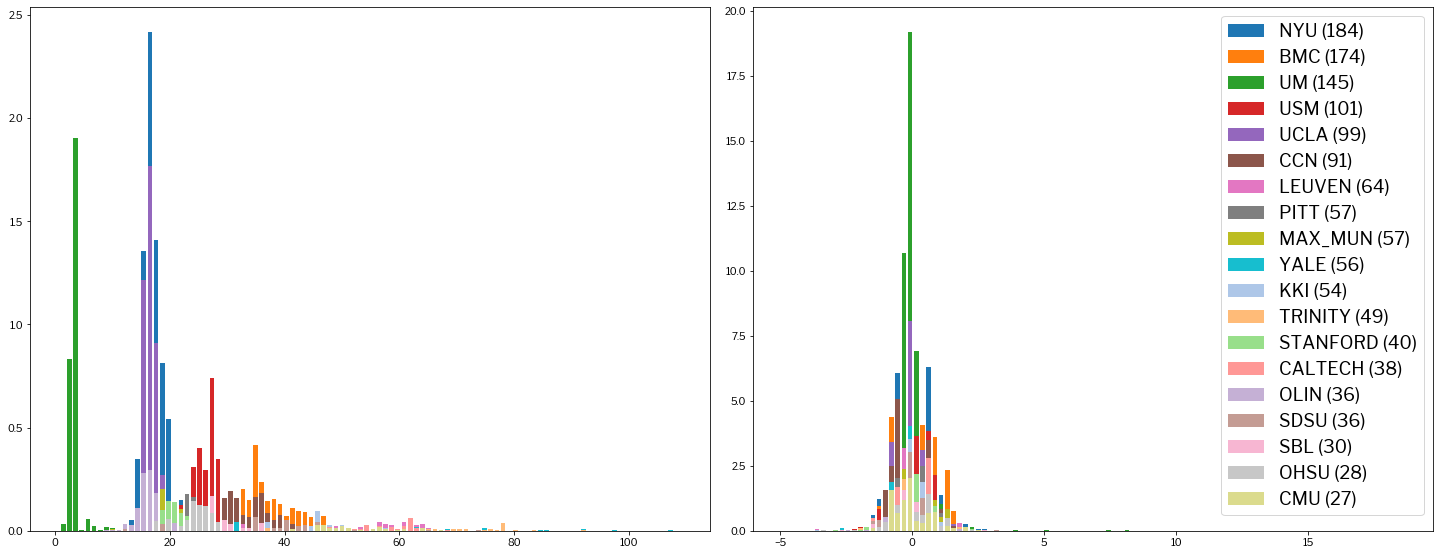

In [10]:
metrics.plot_histogram(merged_x, scaled_x, metric="snrd_total");

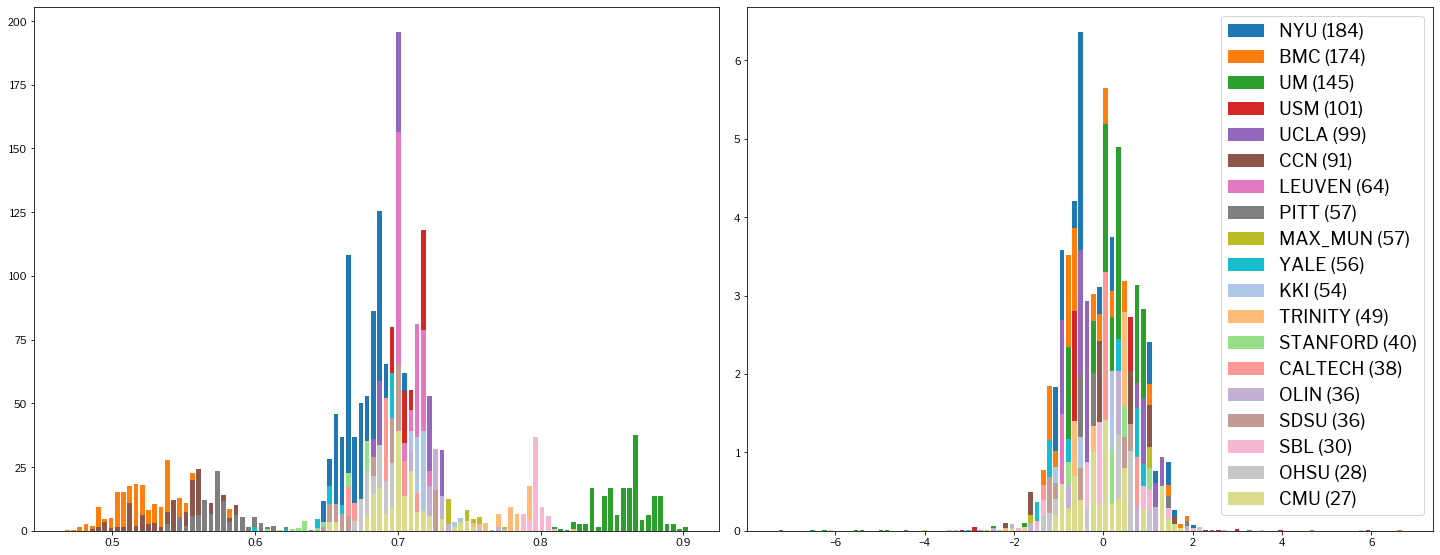

In [11]:
metrics.plot_histogram(merged_x, scaled_x, metric="efc");

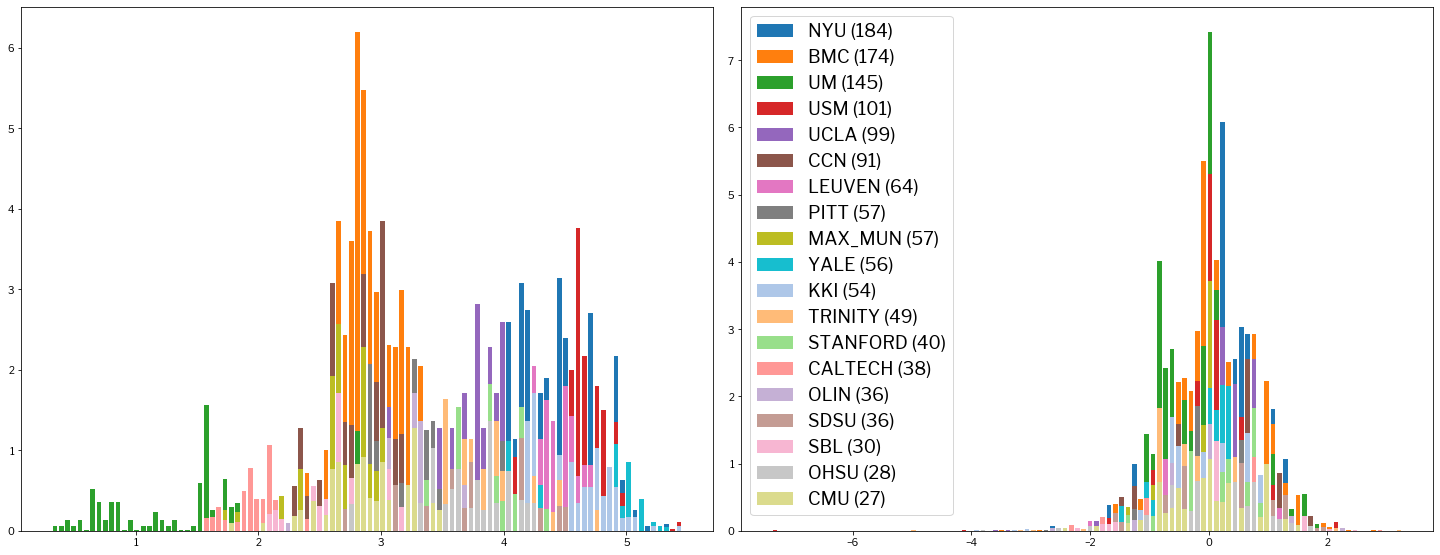

In [12]:
metrics.plot_histogram(merged_x, scaled_x, metric="cnr");

## Metrics are highly correlated

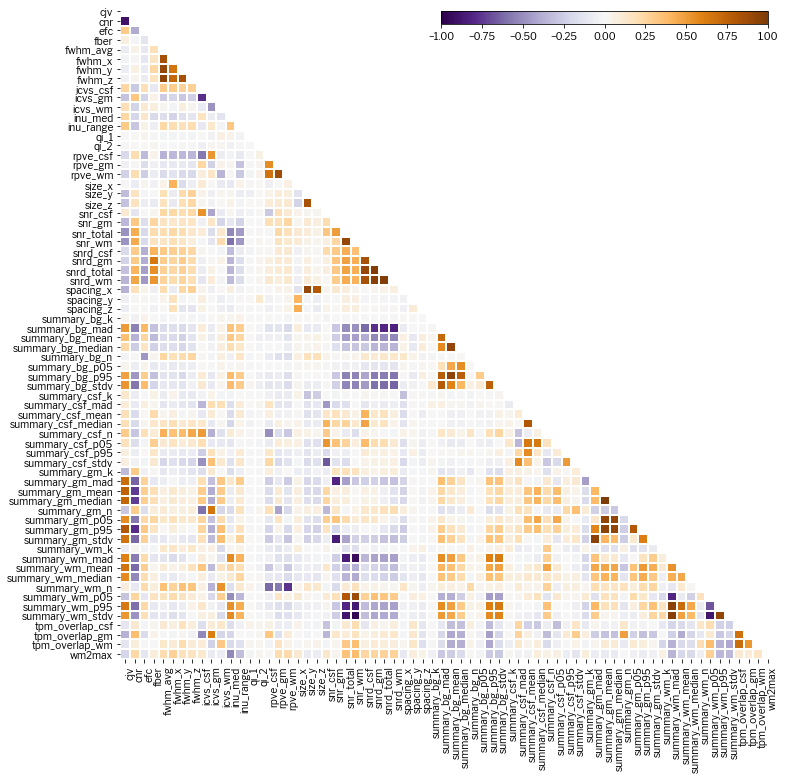

In [13]:
metrics.plot_corrmat(scaled_x[numeric_columns].corr(), figsize=(12, 12));

In [14]:
from mriqc_learn.viz import ratings

In [15]:
train_y

,subject_id,site,rater_1,rater_2,rater_3
0,50002,PITT,NaN,1.0,1
1,50003,PITT,-1.0,NaN,1
2,50004,PITT,NaN,1.0,1
3,50005,PITT,NaN,1.0,1
4,50006,PITT,0.0,1.0,1
...,...,...,...,...,...
1096,51583,SBL,NaN,0.0,1
1097,51584,SBL,-1.0,NaN,1
1098,51585,SBL,NaN,0.0,1
1099,51606,MAX_MUN,0.0,NaN,1


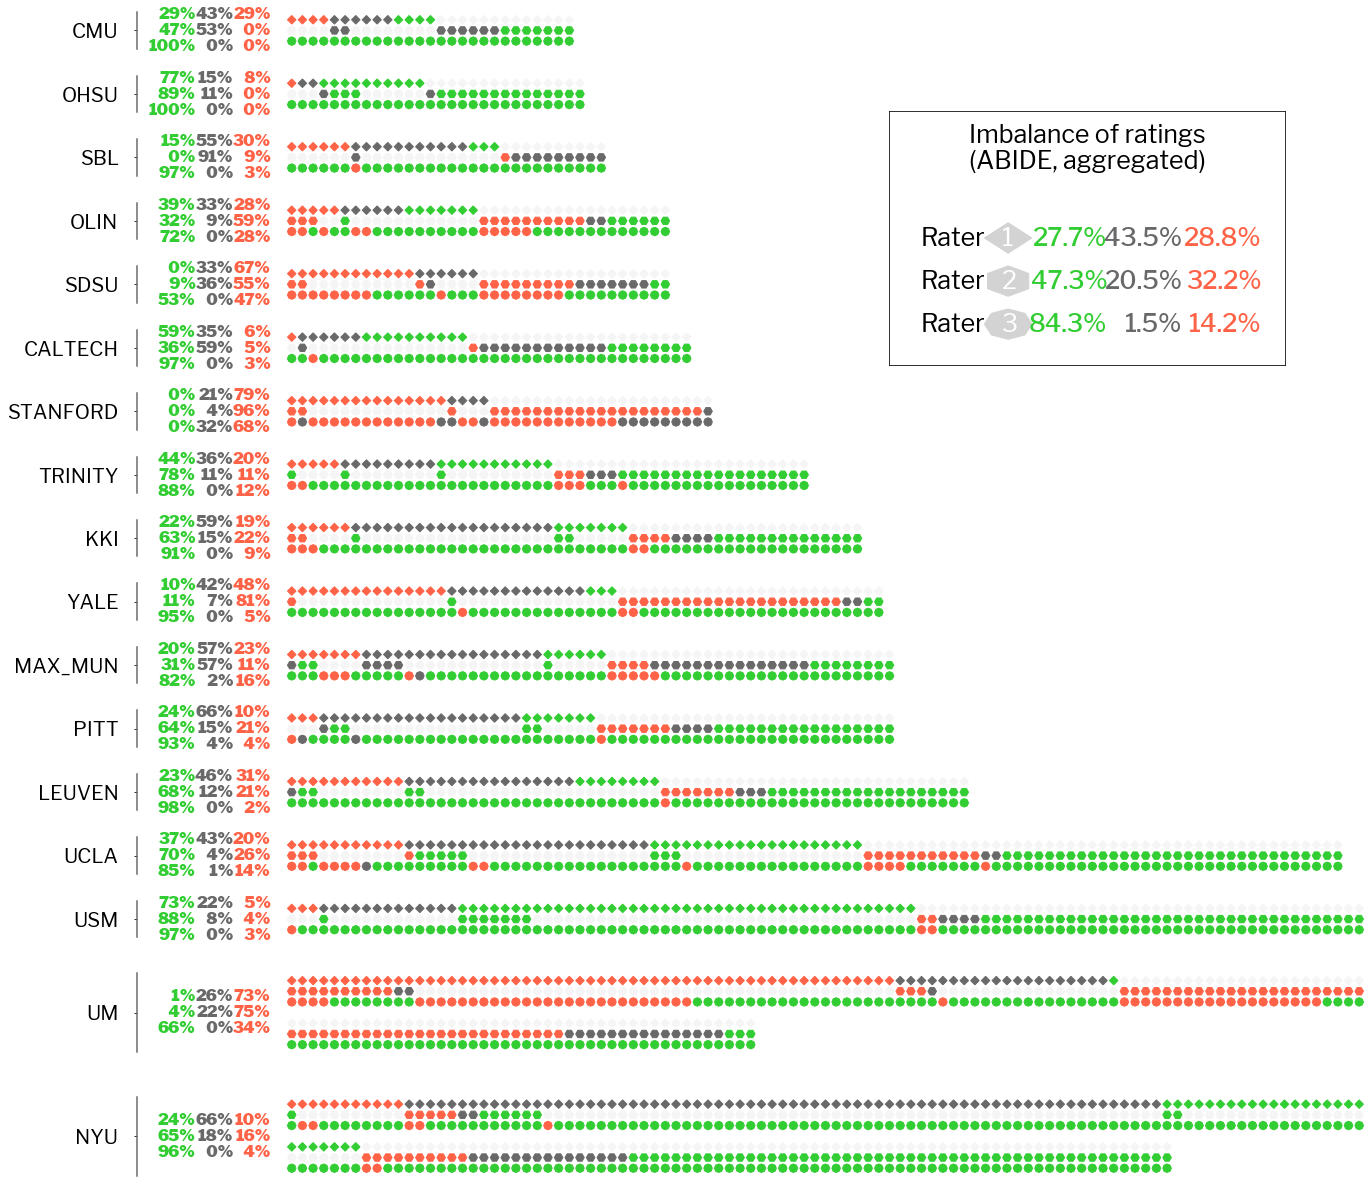

In [16]:
ratings.raters_variability_plot(train_y);